In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import eli5

import regex as re
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


from nltk.corpus import stopwords

import pickle

import os, sys
import warnings
warnings.filterwarnings('ignore')
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# df_reddit = pickle.load(open('../DataSet/df_reddit_for_model.pkl', 'rb'))
df_reddit = pickle.load(open('../DataSet/df_reddit_for_model.pkl', 'rb'))
EDA_df = pickle.load(open('../DataSet/EDA_all_for_model.pkl', 'rb'))
# df_reddit['target'] = df_reddit['subreddit'].replace({"NASA": 1, "Space_discussion": 0})
df_reddit.head(2)

,ent,text_merged,word_count*,sentiment_score*,target,polarity_score,polarity,polarity_VSA,lower_sent,tagged_sent,text_complexity
0,1,star shine saturn ring,4,0.0,1,0.0,1,1,star shine saturn ring,"[(star, NN), (shine, NN), (saturn, NN), (ring,...",92.80
1,2,smithsonian nation air space museum,5,0.0,1,0.0,1,1,smithsonian nation air space museum,"[(smithsonian, JJ), (nation, NN), (air, NN), (...",15.64


In [3]:
EDA_df.head(2)

,target,'',CC,CD,DT,EX,FW,IN,JJ,JJR,...,WP,WP$,WRB,ent,word_count*,sentiment_score*,polarity_score,polarity,polarity_VSA,text_complexity
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,4,0.0,0.0,1,1,92.80
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,2,5,0.0,0.0,1,1,15.64


Defining X and Y variables and use train test split function

In [4]:
X = df_reddit['text_merged']
y = df_reddit['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 101)

cvec = CountVectorizer(min_df=4, max_df=1.0,
                       ngram_range=(1,2),
                       max_features = 3000, strip_accents='ascii')


term_mat = cvec.fit_transform(df_reddit['text_merged'])

Check out the term_matrix as follow.

In [5]:
term_df = pd.DataFrame(term_mat.toarray(), 
                       columns=cvec.get_feature_names())
term_df.insert(0, 'targets', df_reddit['target'])

In [6]:
term_df.head()

,targets,aa,ab,abil,abl,abl see,aboard,aboard intern,aboard space,abort,...,york,youlikebet,young,youtu,zealand,zero,zero graviti,zone,zoom,zubrin
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
term_df.describe()

,targets,aa,ab,abil,abl,abl see,aboard,aboard intern,aboard space,abort,...,york,youlikebet,young,youtu,zealand,zero,zero graviti,zone,zoom,zubrin
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.500000,0.000917,0.002583,0.002417,0.013250,0.001000,0.004750,0.001500,0.001417,0.003167,...,0.001167,0.005750,0.002083,0.007083,0.001083,0.003667,0.000917,0.004333,0.002833,0.001417
std,0.500021,0.035345,0.135689,0.079023,0.128098,0.031608,0.071142,0.038702,0.037614,0.061835,...,0.036498,0.075614,0.047390,0.187624,0.032898,0.070618,0.030264,0.072904,0.061852,0.045623
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,2.000000,14.000000,7.000000,3.000000,1.000000,2.000000,1.000000,1.000000,2.000000,...,2.000000,1.000000,2.000000,12.000000,1.000000,3.000000,1.000000,2.000000,4.000000,3.000000


In [8]:
# scaler = MinMaxScaler()
# scaler.fit(EDA_df)
# EDA_df_normalized = scaler.transform(EDA_df)
# EDA_df_normalized

First lets try Logistic Regression algorithm.

In [9]:
# !pip install pactools
# !/Users/amin/anaconda3/bin/python -m pip install pactools

### A comperhensive grid search on lr model Done.

```python
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])


pipe_params = {
    'cvec__max_features': [2_000, 4_000],
    'cvec__ngram_range': [(1,1), (1,2)],
    'logreg__penalty': ['l2', 'none'],
    'logreg__solver': ['newton-cg', 'sag'],
    'logreg__max_iter': [100, 300]
}

lr = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, 
                  scoring='accuracy', 
                  verbose=2) 

lr.fit(X_train, y_train);
print('lr.best_params_\n', lr.best_params_)
```





### Here is the best results of above grid search.

```python

print('lr.best_params_\n', lr.best_params_)

lr.best_params_
 {'cvec__max_features': 4000, 'cvec__ngram_range': (1, 2), 
 'logreg__max_iter': 300, 'logreg__penalty': 'none', 'logreg__solver': 'sag'}
 
```

In [10]:
# lr.cv_results_

In [11]:
# lr.get_params

Going with best lr hyperparameters.

In [12]:
cvec = CountVectorizer(max_features= 4000,
                       min_df=4, max_df=1.0,
                       ngram_range=(1,2))


X_train_features = cvec.fit_transform(X_train)
X_test_features = cvec.transform(X_test)

lr = LogisticRegression(penalty='none', dual=False, tol=0.0001, 
                         C=1.0, fit_intercept=True, intercept_scaling=1, 
                         class_weight=None, random_state=None, solver='sag', 
                         max_iter=300, multi_class='auto', verbose=0, 
                         warm_start=False, n_jobs=None, l1_ratio=None)

lr.fit(X_train_features, y_train);

lr.score(X_train_features, y_train); 
print('train score', lr.score(X_train_features, y_train))

lr.score(X_test_features, y_test); 
print('test score', lr.score(X_test_features, y_test))

train score 0.7977777777777778
test score 0.7563333333333333


Checking out the Accuracy, Precision, Recall parameters.

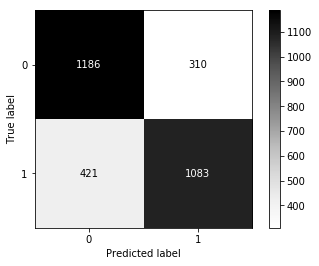

In [13]:
preds = lr.predict(X_test_features)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

plot_confusion_matrix(lr, X_test_features, y_test, 
                      cmap='Greys', values_format='d');
Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall
plt.savefig("../Figures/plot_04_1.png")

In [14]:
# save the model to disk
sys.path.insert(1, '../Codes/')
filename = '../Codes/Models/lr_cvec_DF_P04_01.sav'
pickle.dump(lr, open(filename, 'wb'))

### Applying gradient boosting algorithm.
Using All CPUs

In [15]:
gboost = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, 
                                    n_estimators=100, subsample=1.0, criterion='friedman_mse', 
                                    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                    max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, 
                                    init=None, random_state=None, max_features=None, verbose=0, 
                                    max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, 
                                    n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
gboost_params = {
    'max_depth': [2,3,4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [.08, .1, .12]
}
gs = GridSearchCV(gboost, param_grid=gboost_params, 
                  cv=3, verbose=1, n_jobs=-1)
gs.fit(X_train_features, y_train)

print(gs.best_score_)
gs.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
0.7278888888888888


{'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 150}

just took ~ 8 seconds.
Now using 1 CPU.
### Using One CPU

In [16]:
gboost = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, 
                                    n_estimators=100, subsample=1.0, criterion='friedman_mse', 
                                    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                    max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, 
                                    init=None, random_state=None, max_features=None, verbose=0, 
                                    max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, 
                                    n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
gboost_params = {
    'max_depth': [2,3,4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [.08, .1, .12]
}
gs = GridSearchCV(gboost, param_grid=gboost_params, 
                  cv=3, verbose=1, n_jobs=None)
gs.fit(X_train_features, y_train)

print(gs.best_score_)
gs.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
0.7267777777777779


{'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 150}

60 seconds compare to 8 seconds! 

Going with the best hyperparameters for gboost. Notice grid search convergence to max values.

In [17]:
gboost = GradientBoostingClassifier(loss='deviance', learning_rate=0.12, 
                                    n_estimators=150, subsample=1.0, criterion='friedman_mse', 
                                    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                    max_depth=4, min_impurity_decrease=0.0, min_impurity_split=None, 
                                    init=None, random_state=None, max_features=None, verbose=0, 
                                    max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, 
                                    n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
gboost.fit(X_train_features, y_train)
print(gboost.score(X_test_features, y_test))

0.738


Checking out the Accuracy, Precision, Recall parameters.

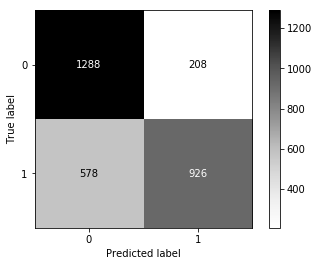

In [18]:
preds = gboost.predict(X_test_features)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

plot_confusion_matrix(gboost, X_test_features, 
                      y_test, cmap='Greys', values_format='d');
Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall
plt.savefig("../Figures/plot_04_2.png")

In [19]:
# save the model to disk
sys.path.insert(1, '../Codes/')
filename = '../Codes/Models/gboost_cvec_DF_P04_01.sav'
pickle.dump(gboost, open(filename, 'wb'))

### Using ANN model 

Using All CPUs.

In [20]:
mlp = MLPClassifier(hidden_layer_sizes=50, activation='relu', solver='adam', 
                    alpha=0.0001, batch_size='auto', learning_rate='constant', 
                    learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
                    random_state=None, tol=0.0001, verbose=False, warm_start=False, 
                    momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                    validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                    n_iter_no_change=10, max_fun=15000)


mlp_params = {
    'hidden_layer_sizes': [20,50],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam']
}
mlp = GridSearchCV(mlp, param_grid=mlp_params, cv=3, verbose=1, n_jobs=-1)
mlp.fit(X_train_features, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=MLPClassifier(hidden_layer_sizes=50), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [20, 50],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=1)

In [21]:
print(mlp.best_score_)
mlp.best_params_

0.7436666666666666


{'activation': 'tanh', 'hidden_layer_sizes': 50, 'solver': 'sgd'}

Checking out the Accuracy, Precision, Recall parameters.

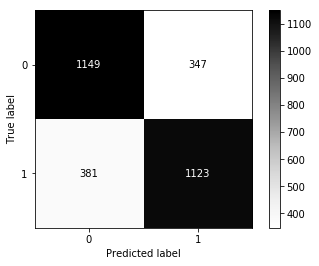

In [22]:
preds = mlp.predict(X_test_features)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

plot_confusion_matrix(mlp, X_test_features, y_test, 
                      cmap='Greys', values_format='d');
Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall
plt.savefig("../Figures/plot_04_3.png")

Going with the best hyperparameters for ANN. 

In [23]:
mlp = MLPClassifier(hidden_layer_sizes=50, activation='relu', solver='sgd', 
                    alpha=0.0001, batch_size='auto', learning_rate='constant', 
                    learning_rate_init=0.001, power_t=0.5, max_iter=100, shuffle=True, 
                    random_state=None, tol=0.0001, verbose=False, warm_start=False, 
                    momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                    validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                    n_iter_no_change=10, max_fun=15000)


mlp.fit(X_train_features, y_train)
print(mlp.score(X_test_features, y_test))

0.748


In [24]:
# save the model to disk
sys.path.insert(1, '../Codes/')
filename = '../Codes/Models/mlp_cvec_DF_P04_01.sav'
pickle.dump(mlp, open(filename, 'wb'))

## Lets use EDA data

In [25]:
EDA_df.head(2)

,target,'',CC,CD,DT,EX,FW,IN,JJ,JJR,...,WP,WP$,WRB,ent,word_count*,sentiment_score*,polarity_score,polarity,polarity_VSA,text_complexity
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,4,0.0,0.0,1,1,92.80
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,2,5,0.0,0.0,1,1,15.64


Lets make a normalzied set of EDA data.

In [26]:
from sklearn import preprocessing
EDA_arr = EDA_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
EDA_arr_scaled = min_max_scaler.fit_transform(EDA_arr)
EDA_df_normalized = pd.DataFrame(EDA_arr_scaled, columns=EDA_df.columns)
EDA_df_normalized.head()

,target,'',CC,CD,DT,EX,FW,IN,JJ,JJR,...,WP,WP$,WRB,ent,word_count*,sentiment_score*,polarity_score,polarity,polarity_VSA,text_complexity
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.003015,0.499549,0.5,0.5,0.5,0.899776
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005076,0.0,...,0.0,0.0,0.0,0.090909,0.004020,0.499549,0.5,0.5,0.5,0.831964
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005076,0.0,...,0.0,0.0,0.0,0.000000,0.003015,0.659032,0.5,0.5,0.5,0.847730
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.002010,0.499549,0.5,0.5,0.5,0.848618
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005076,0.0,...,0.0,0.0,0.0,0.000000,0.007035,0.729501,0.5,0.5,0.5,0.881338


Prepare the data frame as numpy.

train score 0.8264444444444444
test score 0.8216666666666667


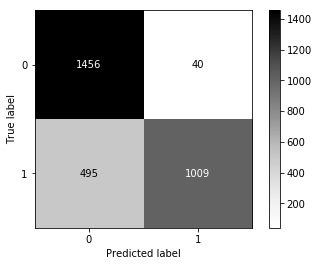

In [27]:
y = EDA_df['target']
X = EDA_df.drop(columns = ['target'])
X_arr = np.array(X)
y_arr = np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X_arr,
                                                    y_arr,
                                                    test_size = 0.25,
                                                    random_state = 101)


lr = LogisticRegression(solver='sag', 
                        max_iter=5000)

lr.fit(X_train, y_train);

lr.score(X_train, y_train); 
print('train score', lr.score(X_train, y_train))

lr.score(X_test, y_test); 
print('test score', lr.score(X_test, y_test))


preds = lr.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

plot_confusion_matrix(lr, X_test, y_test, 
                      cmap='Greys', values_format='d');
Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall
plt.savefig("../Figures/plot_04_4.png")

In [28]:
# save the model to disk
sys.path.insert(1, '../Codes/')
filename = '../Codes/Models/lr_EDA_DF_P04_01.sav'
pickle.dump(lr, open(filename, 'wb'))

* Now lets use the normalized data set and see if it affects the reults.

train score 0.8356666666666667
test score 0.832


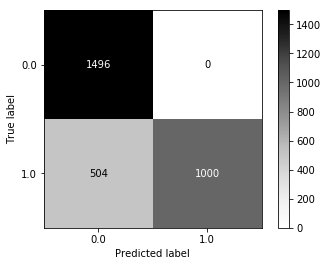

In [29]:
y = EDA_df_normalized['target']
X = EDA_df_normalized.drop(columns = ['target'])
X_arr = np.array(X)
y_arr = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_arr,
                                                    y_arr,
                                                    test_size = 0.25,
                                                    random_state = 101)


lr = LogisticRegression(solver='sag', 
                        max_iter=5000)

lr.fit(X_train, y_train);

lr.score(X_train, y_train); 
print('train score', lr.score(X_train, y_train))

lr.score(X_test, y_test); 
print('test score', lr.score(X_test, y_test))

preds = lr.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

plot_confusion_matrix(lr, X_test, y_test, 
                      cmap='Greys', values_format='d');
Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall
plt.savefig("../Figures/plot_04_5.png")

In [30]:
# save the model to disk
sys.path.insert(1, '../Codes/')
filename = '../Codes/Models/lr_EDA_norm_DF_P04_01.sav'
pickle.dump(lr, open(filename, 'wb'))

### Gboost algorithm
Now lets use Gboost algorithm.

In [31]:
y = EDA_df['target']
X = EDA_df.drop(columns = ['target'])
X_arr = np.array(X)
y_arr = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_arr,
                                                    y_arr,
                                                    test_size = 0.25,
                                                    random_state = 101)


gboost = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, 
                                    n_estimators=100, subsample=1.0, criterion='friedman_mse', 
                                    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                    max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, 
                                    init=None, random_state=None, max_features=None, verbose=0, 
                                    max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, 
                                    n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
gboost_params = {
    'max_depth': [2,3,4],
    'n_estimators': [100, 250, 500],
    'learning_rate': [.08, .1, .12]
}
gs = GridSearchCV(gboost, param_grid=gboost_params, 
                  cv=3, verbose=1, n_jobs=-1)
gs.fit(X_train, y_train)

print(gs.best_score_)
gs.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
0.8353333333333334


{'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 100}

and going down with the best hyperparameters

In [32]:
gboost = GradientBoostingClassifier(loss='deviance', learning_rate=0.08, 
                                    n_estimators=100, subsample=1.0, criterion='friedman_mse', 
                                    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                    max_depth=2, min_impurity_decrease=0.0, min_impurity_split=None, 
                                    init=None, random_state=None, max_features=None, verbose=0, 
                                    max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, 
                                    n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
gboost.fit(X_train, y_train)
print(gboost.score(X_test, y_test))

0.8316666666666667


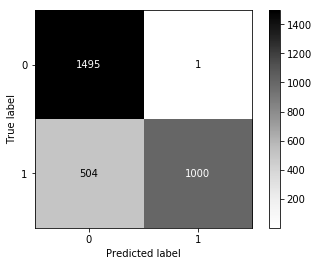

In [33]:
preds = gboost.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

plot_confusion_matrix(gboost, X_test, y_test, 
                      cmap='Greys', values_format='d');
Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall
plt.savefig("../Figures/plot_04_6.png")

In [34]:
# save the model to disk
sys.path.insert(1, '../Codes/')
filename = '../Codes/Models/gboost_EDA_DF_P04_01.sav'
pickle.dump(gboost, open(filename, 'wb'))

Gboost using normalized EDA data set.

0.8316666666666667
train score 0.8361111111111111
test score 0.8316666666666667


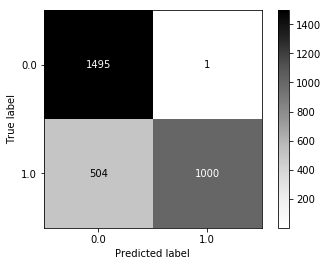

In [35]:
y = EDA_df_normalized['target']
X = EDA_df_normalized.drop(columns = ['target'])
X_arr = np.array(X)
y_arr = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_arr,
                                                    y_arr,
                                                    test_size = 0.25,
                                                    random_state = 101)


gboost = GradientBoostingClassifier(loss='deviance', learning_rate=0.08, 
                                    n_estimators=100, subsample=1.0, criterion='friedman_mse', 
                                    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                    max_depth=2, min_impurity_decrease=0.0, min_impurity_split=None, 
                                    init=None, random_state=None, max_features=None, verbose=0, 
                                    max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, 
                                    n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
gboost.fit(X_train, y_train)
print(gboost.score(X_test, y_test))



gboost.fit(X_train, y_train);

gboost.score(X_train, y_train); 
print('train score', gboost.score(X_train, y_train))

gboost.score(X_test, y_test); 
print('test score', gboost.score(X_test, y_test))


preds = gboost.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

plot_confusion_matrix(gboost, X_test, y_test, 
                      cmap='Greys', values_format='d');
Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall
plt.savefig("../Figures/plot_04_7.png")

In [36]:
# save the model to disk
sys.path.insert(1, '../Codes/')
filename = '../Codes/Models/gboost_EDA_norm_DF_P04_01.sav'
pickle.dump(gboost, open(filename, 'wb'))

### ANN using all CPUs

Grid search.

In [37]:
y = EDA_df['target']
X = EDA_df.drop(columns = ['target'])
X_arr = np.array(X)
y_arr = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_arr,
                                                    y_arr,
                                                    test_size = 0.25,
                                                    random_state = 101)


mlp = MLPClassifier(hidden_layer_sizes=50, activation='relu', solver='adam', 
                    alpha=0.0001, batch_size='auto', learning_rate='constant', 
                    learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
                    random_state=None, tol=0.0001, verbose=False, warm_start=False, 
                    momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                    validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                    n_iter_no_change=10, max_fun=15000)


mlp_params = {
    'hidden_layer_sizes': [20,50],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam']
}
mlp = GridSearchCV(mlp, param_grid=mlp_params, cv=3, verbose=1, n_jobs=-1)
mlp.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=MLPClassifier(hidden_layer_sizes=50), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [20, 50],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=1)

In [38]:
print(mlp.best_score_)
mlp.best_params_

0.8295555555555555


{'activation': 'tanh', 'hidden_layer_sizes': 20, 'solver': 'adam'}

Going down with best hyperparameters.

0.8276666666666667


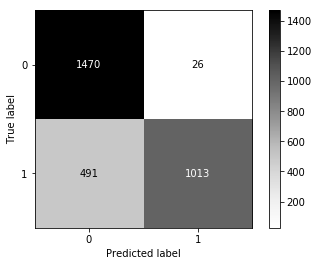

In [39]:
mlp = MLPClassifier(hidden_layer_sizes=50, activation='tanh', solver='adam', 
                    alpha=0.0001, batch_size='auto', learning_rate='constant', 
                    learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
                    random_state=None, tol=0.0001, verbose=False, warm_start=False, 
                    momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                    validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                    n_iter_no_change=10, max_fun=15000)


mlp.fit(X_train, y_train)
print(mlp.score(X_test, y_test))



preds = mlp.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix
plot_confusion_matrix(mlp, X_test, y_test, 
                      cmap='Greys', values_format='d');
Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall
plt.savefig("../Figures/plot_04_8.png")

In [40]:
# save the model to disk
sys.path.insert(1, '../Codes/')
filename = '../Codes/Models/mlp_EDA_DF_P04_01.sav'
pickle.dump(mlp, open(filename, 'wb'))

Now using normalized data.

0.831


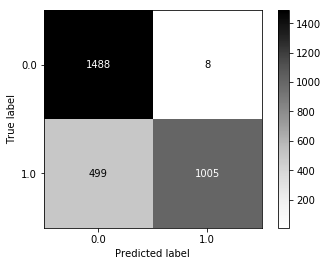

In [41]:
y = EDA_df_normalized['target']
X = EDA_df_normalized.drop(columns = ['target'])
X_arr = np.array(X)
y_arr = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_arr,
                                                    y_arr,
                                                    test_size = 0.25,
                                                    random_state = 101)


mlp = MLPClassifier(hidden_layer_sizes=50, activation='tanh', solver='adam', 
                    alpha=0.0001, batch_size='auto', learning_rate='constant', 
                    learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
                    random_state=None, tol=0.0001, verbose=False, warm_start=False, 
                    momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                    validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                    n_iter_no_change=10, max_fun=15000)


mlp.fit(X_train, y_train)
print(mlp.score(X_test, y_test))



preds = mlp.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix
plot_confusion_matrix(mlp, X_test, y_test, 
                      cmap='Greys', values_format='d');
Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall
plt.savefig("../Figures/plot_04_9.png")

In [42]:
# save the model to disk
sys.path.insert(1, '../Codes/')
filename = '../Codes/Models/mlp_EDA_norm_DF_P04_01.sav'
pickle.dump(mlp, open(filename, 'wb'))

Let's monitor the progress of algorithms.

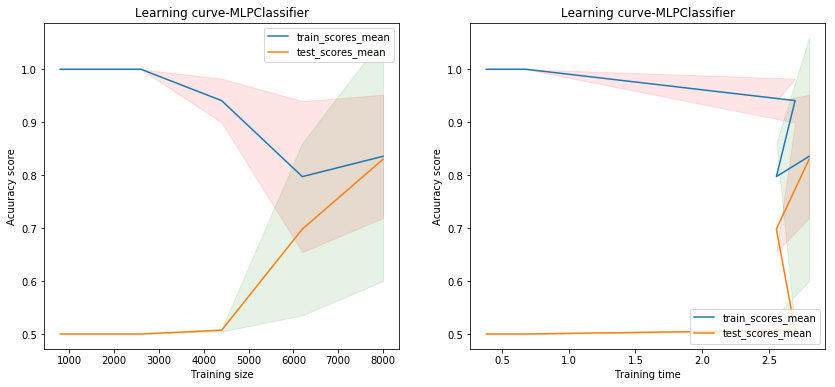

In [43]:
estimator = MLPClassifier(hidden_layer_sizes=50, activation='tanh', solver='adam', 
                    alpha=0.0001, batch_size='auto', learning_rate='constant', 
                    learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
                    random_state=None, tol=0.0001, verbose=False, warm_start=False, 
                    momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                    validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                    n_iter_no_change=10, max_fun=15000)

X = np.array(X)
y = np.array(y)

train_sizes, train_scores, test_scores, fit_times, _ =\
                                       learning_curve(estimator, X, y, scoring='accuracy',
                                                      cv=3, n_jobs=-1,
                                                      train_sizes=np.linspace(.1, 1.0, 5),
                                                      return_times=True)


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(train_sizes, train_scores_mean, label='train_scores_mean')
plt.fill_between(train_sizes, train_scores_mean-train_scores_std, 
                 train_scores_mean+train_scores_std, alpha=0.1,
                         color="r")


plt.plot(train_sizes, test_scores_mean, label='test_scores_mean')
plt.fill_between(train_sizes, test_scores_mean-test_scores_std, 
                 test_scores_mean+test_scores_std, alpha=0.1,
                         color="g")

# plt.ylim(0,1)
plt.title('Learning curve-MLPClassifier')
plt.ylabel('Acuuracy score')
plt.xlabel('Training size')
plt.legend(loc='best')



plt.subplot(1,2,2)

# plt.figure(figsize=(8,6))
plt.plot(fit_times_mean,train_scores_mean, label='train_scores_mean')
plt.fill_between(fit_times_mean, train_scores_mean-train_scores_std, 
                 train_scores_mean+train_scores_std, alpha=0.1,
                         color="r")
plt.plot(fit_times_mean,test_scores_mean, label='test_scores_mean')
plt.fill_between(fit_times_mean, test_scores_mean-test_scores_std, 
                 test_scores_mean+test_scores_std, alpha=0.1,
                         color="g")
# plt.ylim(0.5,1.1)
plt.title('Learning curve-MLPClassifier')
plt.ylabel('Acuuracy score')
plt.xlabel('Training time')
plt.legend(loc='lower right')
plt.savefig("../Figures/plot_04_10.png")

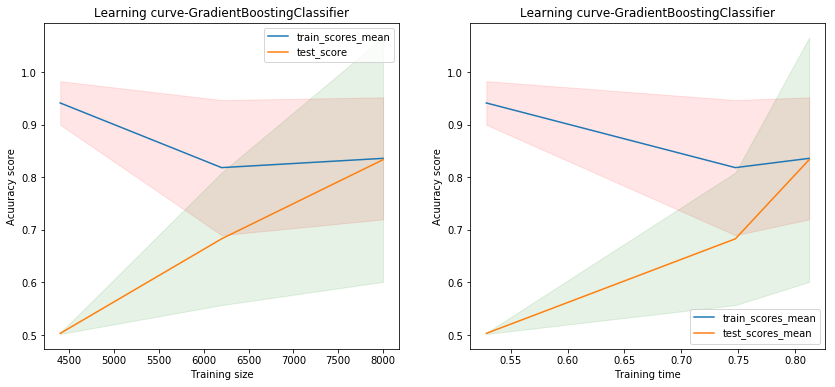

In [44]:
estimator = GradientBoostingClassifier(loss='deviance', learning_rate=0.08, 
                                    n_estimators=100, subsample=1.0, criterion='friedman_mse', 
                                    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                    max_depth=2, min_impurity_decrease=0.0, min_impurity_split=None, 
                                    init=None, random_state=None, max_features=None, verbose=0, 
                                    max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, 
                                    n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

X = np.array(X)
y = np.array(y)

train_sizes, train_scores, test_scores, fit_times, _ =\
                                       learning_curve(estimator, X, y, 
                                                      cv=3, n_jobs=-1,
                                                      train_sizes=np.linspace(.1, 1.0, 5),
                                                      return_times=True)


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)



plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(train_sizes, train_scores_mean, label='train_scores_mean')
plt.fill_between(train_sizes, train_scores_mean-train_scores_std, 
                 train_scores_mean+train_scores_std, alpha=0.1,
                         color="r")

plt.plot(train_sizes, test_scores_mean, label='test_score')
plt.fill_between(train_sizes, test_scores_mean-test_scores_std, 
                 test_scores_mean+test_scores_std, alpha=0.1,
                         color="g")

plt.title('Learning curve-GradientBoostingClassifier')
plt.ylabel('Acuuracy score')
plt.xlabel('Training size')
plt.legend(loc='best')


plt.subplot(1,2,2)
# plt.figure(figsize=(8,6))
plt.plot(fit_times_mean,train_scores_mean, label='train_scores_mean')
plt.fill_between(fit_times_mean, train_scores_mean-train_scores_std, 
                 train_scores_mean+train_scores_std, alpha=0.1,
                         color="r")
plt.plot(fit_times_mean,test_scores_mean, label='test_scores_mean')
plt.fill_between(fit_times_mean, test_scores_mean-test_scores_std, 
                 test_scores_mean+test_scores_std, alpha=0.1,
                         color="g")
# plt.ylim(0.5,1.1)
plt.title('Learning curve-GradientBoostingClassifier')
plt.ylabel('Acuuracy score')
plt.xlabel('Training time')
plt.legend(loc='lower right')
plt.savefig("../Figures/plot_04_11.png")

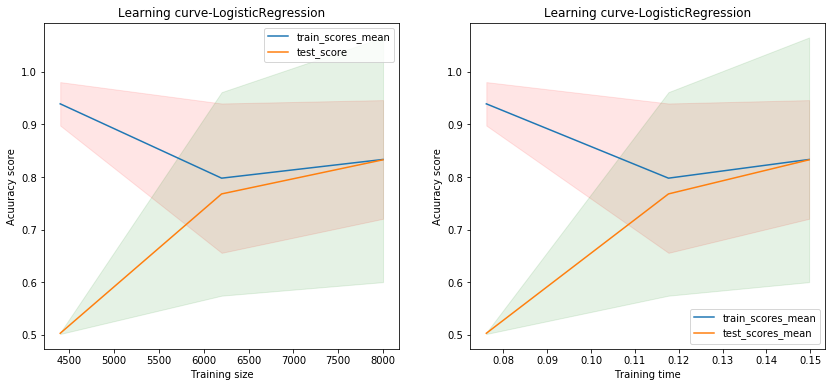

In [45]:
estimator = LogisticRegression(solver='sag', 
                        max_iter=5000)
X = np.array(X)
y = np.array(y)

train_sizes, train_scores, test_scores, fit_times, _ =\
                                       learning_curve(estimator, X, y, 
                                                      cv=3, n_jobs=-1,
                                                      train_sizes=np.linspace(.1, 1.0, 5),
                                                      return_times=True)


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)


plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(train_sizes, train_scores_mean, label='train_scores_mean')
plt.fill_between(train_sizes, train_scores_mean-train_scores_std, 
                 train_scores_mean+train_scores_std, alpha=0.1,
                         color="r")

plt.plot(train_sizes, test_scores_mean, label='test_score')
plt.fill_between(train_sizes, test_scores_mean-test_scores_std, 
                 test_scores_mean+test_scores_std, alpha=0.1,
                         color="g")

plt.title('Learning curve-LogisticRegression')
plt.ylabel('Acuuracy score')
plt.xlabel('Training size')
plt.legend(loc='best')



plt.subplot(1,2,2)
plt.plot(fit_times_mean,train_scores_mean, label='train_scores_mean')
plt.fill_between(fit_times_mean, train_scores_mean-train_scores_std, 
                 train_scores_mean+train_scores_std, alpha=0.1,
                         color="r")
plt.plot(fit_times_mean,test_scores_mean, label='test_scores_mean')
plt.fill_between(fit_times_mean, test_scores_mean-test_scores_std, 
                 test_scores_mean+test_scores_std, alpha=0.1,
                         color="g")
# plt.ylim(0.5,1.1)
plt.title('Learning curve-LogisticRegression')
plt.ylabel('Acuuracy score')
plt.xlabel('Training time')
plt.legend(loc='lower right')
plt.savefig("../Figures/plot_04_12.png")

#### It was observed that the EDA data set works better and helps the ML algorithm to find patterns.
#### Next we merge both df sets and try different ML algorithms.